In [30]:
import matplotlib.pyplot as plt
import os

([], <a list of 0 Text yticklabel objects>)

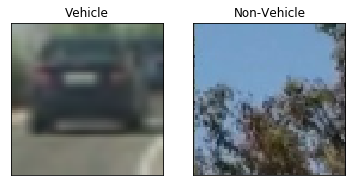

In [45]:
#plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
vehicle = plt.imread('vehicles/GTI_Far/image0001.png')
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
non_vehicle = plt.imread('non-vehicles/Extras/extra2.png')
plt.imshow(non_vehicle)
plt.title('Non-Vehicle')
plt.xticks([])
plt.yticks([])

In [32]:

### 1.  HOG features

#The code for HOG feature extraction can be found in `feature_extraction.py`.  

#I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

([], <a list of 0 Text yticklabel objects>)

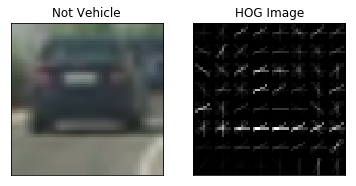

In [47]:
from feature_extraction import *

plt.subplot(1,2,1)
plt.imshow(vehicle)
plt.title('Not Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
features, hog = get_hog_features(vehicle[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
plt.imshow(hog, cmap='gray')
plt.title('HOG Image')
plt.xticks([])
plt.yticks([])

In [34]:
# ### 2. Feature Extraction for Model

# #I tried various combinations of color spaces and parameters before finally settling with following:

# ```
# color_space = 'YCrCb'
# spatial_size = (32, 32)
# hist_bins = 32
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 'ALL'
# spatial_feat = True
# hist_feat = True
# hog_feat = True
# ```

In [35]:
import pickle 

## Load model params
with open('vehicle_detection_model.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data

In [36]:
## Vehicle Detection Pipeline

### 1. Sliding Window Search

([], <a list of 0 Text yticklabel objects>)

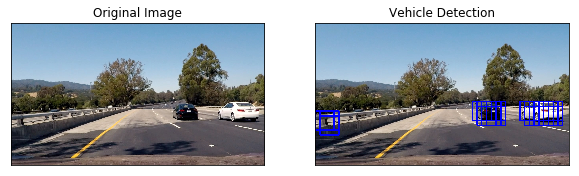

In [37]:
img = mpimg.imread('test_images/test4.jpg')


ystart = 400
ystop = 656
scale = 1.5
   
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(out_img)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])

In [38]:
# ### 2. Multi-Scale Search

# The scale for the multi-window search and overlap to be considered was decided emperically.

# The multi-scale window approach prevents calculation of feature vectors for the complete image and thus helps in speeding up the process. The following scales were emperically decided each having a overlap of `75%` (decided by `cells_per_step` which is set as `2`):


# Scale 1:
# ```
# ystart = 380
# ystop = 480
# scale = 1
# ```

# Scale 2:
# ```
# ystart = 400
# ystop = 600
# scale = 1.5
# ```

# Scale 3:
# ```
# ystart = 500
# ystop = 700
# scale = 2.5
# ```

# The figure below shows the multiple scales under consideration overlapped on image.

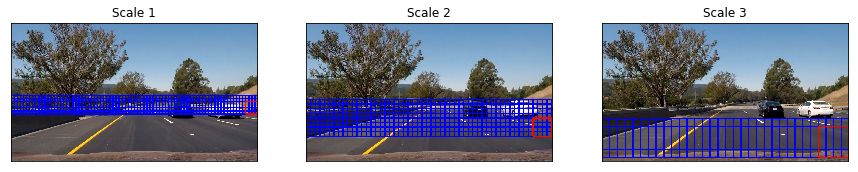

In [39]:
def draw_multi_scale_windows(img, ystart, ystop, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    imshape = img_tosearch.shape
    img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (xbox_left, ytop_draw + ystart)
            rect_end = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            cv2.rectangle(draw_img, rect_start, rect_end, (0, 0, 255), 6)
    
    cv2.rectangle(draw_img, rect_start, rect_end, (255, 0, 0), 6)

    return draw_img

img = mpimg.imread('test_images/test6.jpg')

plt.figure(figsize=(15,40))
subpltcount=1
for (ystart, ystop, scale) in [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]:
    plt.subplot(1,3,subpltcount)
    plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1

In [40]:
#### C. Heatmaps and Label Detection

([], <a list of 0 Text yticklabel objects>)

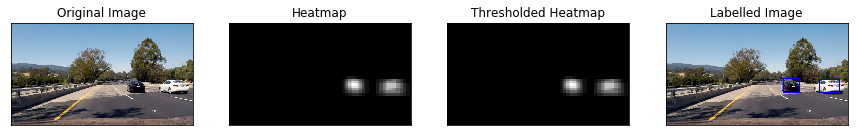

In [41]:
from vehicle_detector import VehicleDetector
vehicleDetector = VehicleDetector('vehicle_detection_model.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 5


img = mpimg.imread('test_images/test4.jpg')
out = vehicleDetector.find_cars(img)


plt.figure(figsize=(15,40))

## Input Image
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])


## Heatmap
plt.subplot(142)
heatmap = vehicleDetector.heat_images[0]
plt.imshow(heatmap, cmap='gray')
plt.title('Heatmap')
plt.xticks([])
plt.yticks([])

## Thresholded Heatmap
plt.subplot(143)
t_heatmap = vehicleDetector.heatmap
plt.imshow(heatmap, cmap='gray')
plt.title('Thresholded Heatmap')
plt.xticks([])
plt.yticks([])

## Label Detection
plt.subplot(144)
from scipy.ndimage.measurements import label
labels = label(t_heatmap)
labelled_image = np.copy(img)
VehicleDetector.draw_labeled_bboxes(labelled_image, labels)
plt.imshow(labelled_image)
plt.title('Labelled Image')
plt.xticks([])
plt.yticks([])

In [42]:
##Search Optimization 

([], <a list of 0 Text yticklabel objects>)

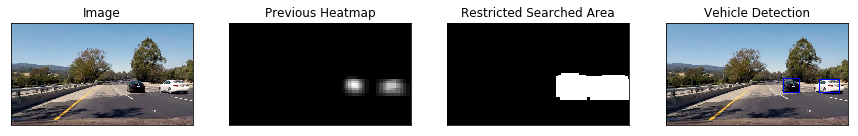

In [43]:
plt.figure(figsize=(15,50))
plt.subplot(141)
plt.imshow(img)
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.imshow(heatmap, cmap='gray')
plt.title('Previous Heatmap')
plt.xticks([])
plt.yticks([])

plt.subplot(143)
mask = np.sum(np.array(vehicleDetector.heat_images), axis=0)
mask[(mask > 0)] = 1
mask = cv2.dilate(mask, vehicleDetector.kernel, iterations=1)
plt.imshow(mask, cmap='gray')
plt.title('Restricted Searched Area')
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.imshow(out)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])

In [44]:
from vehicle_detector import VehicleDetector
vehicleDetector = VehicleDetector('vehicle_detection_model.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (400, 656, 2.5)]
vehicleDetector.threshold = 2

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(vehicleDetector.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:28<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 14s, sys: 21.9 s, total: 7min 36s
Wall time: 4min 29s
